In [1]:
# for local
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

EXP_NAME='1011_lstm_hidden=1024_4layer_dropout=0.0_mod-feat1'

DATA_DIR = "../input/ventilator-pressure-prediction/"

OUTPUT_DIR = f'./results/{EXP_NAME}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    experiment_name=EXP_NAME
    competition='ventilator'
    apex=True
    print_freq=1000
    num_workers=4
    model_name='lstm'
    scheduler='CosineAnnealingWarmRestarts' # ['linear', 'cosine', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    batch_scheduler=False
    #num_warmup_steps=100 # ['linear', 'cosine']
    #num_cycles=0.5 # 'cosine'
    factor=0.995 # ReduceLROnPlateau
    patience=7 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=50 # CosineAnnealingLR
    T_0=20 # CosineAnnealingWarmRestarts
    epochs=300
    max_grad_norm=1000
    gradient_accumulation_steps=1
    hidden_size=1024
    lr=1e-3
    min_lr=1e-5
    weight_decay=1e-6
    batch_size=256
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    cate_seq_cols=[]
    cont_seq_cols=['R', 'C', 'time_step', 'u_in', 'u_out']
    train=False
    inference=False
    feature_importance=True
    debug=False
    wandb=True

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold=[0]

# import

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import json
import math
import random
from time import time
from datetime import datetime
from collections import Counter, defaultdict

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from tqdm.auto import tqdm
import category_encoders as ce

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")

#if CFG.apex:
#    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# wandb

In [5]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb

    # try:
    #     from kaggle_secrets import UserSecretsClient
    #     user_secrets = UserSecretsClient()
    #     secret_value_0 = user_secrets.get_secret("wandb_api")
    #     wandb.login(key=secret_value_0)
    #     anony = None
    # except:
    #     anony = "must"
    #     print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

    anony=None # not for kaggle kernel

    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project="Ventilator-Pressure-Public", 
                     # name=CFG.model_name,
                     config=class2dict(CFG),
                     group=CFG.experiment_name,
                     job_type="train",
                     anonymous=anony)

wandb: Currently logged in as: hypknot (use `wandb login --relogin` to force relogin)

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_trues, y_preds):
    score = mean_absolute_error(y_trues, y_preds)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# data loading

In [7]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(DATA_DIR + 'train.csv')
if CFG.debug:
    train = train[:80*5000]
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

display(train.head())
display(test.head())
display(sub.head())

unique_pressures = train["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)
total_pressures_len = len(sorted_pressures)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# create features

In [8]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()


class AddMultiplyingDividing(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['area'] = input_df['time_step'] * input_df['u_in']
        input_df['area'] = input_df.groupby('breath_id')['area'].cumsum()
        input_df['cross'] = input_df['u_in']*input_df['u_out']
        input_df['cross2'] = input_df['time_step']*input_df['u_out']
        input_df['u_in_cumsum'] = (input_df['u_in']).groupby(input_df['breath_id']).cumsum()
        input_df['one'] = 1
        input_df['count'] = (input_df['one']).groupby(input_df['breath_id']).cumsum()
        input_df['u_in_cummean'] = input_df['u_in_cumsum'] / input_df['count']
        input_df = input_df.merge(
            input_df[input_df["u_out"]==0].groupby('breath_id')['u_in'].agg(["mean", "std", "max"]).add_prefix("u_out0_").reset_index(),
            on="breath_id"
        )
        input_df = input_df.merge(
            input_df[input_df["u_out"]==1].groupby('breath_id')['u_in'].agg(["mean", "std", "max"]).add_prefix("u_out1_").reset_index(),
            on="breath_id"
        )

        output_df = pd.DataFrame(
            {
                "area": input_df['area'],
                #"cross": input_df['cross'],
                #"cross2": input_df['cross2'],
                "u_in_cumsum": input_df['u_in_cumsum'],
                "u_in_cummean": input_df['u_in_cummean'],
                "u_out0_mean": input_df['u_out0_mean'],
                "u_out0_max": input_df['u_out0_max'],
                "u_out0_max": input_df['u_out0_std'],
                "u_out1_mean": input_df['u_out1_mean'],
                "u_out1_max": input_df['u_out1_max'],
                "u_out1_max": input_df['u_out1_std'],
            }
        )
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df


class RCDummry(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['R_dummy'] = input_df['R'].astype(str)
        input_df['C_dummy'] = input_df['C'].astype(str)
        #input_df['RC_dummy'] = input_df['R_dummy'] + input_df['C_dummy']
        output_df = pd.get_dummies(input_df[["R_dummy", "C_dummy"]])
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df


class AddBreathTimeAndUInTime(AbstractBaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame(
            {
                "breath_time": input_df['time_step'] - input_df['time_step'].shift(1),
                "u_in_time": input_df['u_in'] - input_df['u_in'].shift(1)
            }
        )
        output_df.loc[input_df['time_step'] == 0, 'breath_time'] = output_df['breath_time'].mean()
        output_df.loc[input_df['time_step'] == 0, 'u_in_time'] = output_df['u_in_time'].mean()
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df

class LagFeatures(AbstractBaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame(
            {
                "u_in_lag1": input_df.groupby("breath_id")["u_in"].shift(1).fillna(0),
                "u_in_lag2": input_df.groupby("breath_id")["u_in"].shift(2).fillna(0),
                "u_in_lag3": input_df.groupby("breath_id")["u_in"].shift(3).fillna(0),
                "u_in_lag4": input_df.groupby("breath_id")["u_in"].shift(4).fillna(0),
                "u_in_lag5": input_df.groupby("breath_id")["u_in"].shift(4).fillna(0),
                "u_in_lag10": input_df.groupby("breath_id")["u_in"].shift(10).fillna(0),
                "u_in_lag15": input_df.groupby("breath_id")["u_in"].shift(15).fillna(0),
                "u_in_lag20": input_df.groupby("breath_id")["u_in"].shift(20).fillna(0),
                "u_in_lag-1": input_df.groupby("breath_id")["u_in"].shift(-1).fillna(0),
                "u_in_lag-2": input_df.groupby("breath_id")["u_in"].shift(-2).fillna(0),
                "u_in_lag-3": input_df.groupby("breath_id")["u_in"].shift(-3).fillna(0),
                "u_in_lag-4": input_df.groupby("breath_id")["u_in"].shift(-4).fillna(0),
                "u_out_lag1": input_df.groupby("breath_id")["u_out"].shift(1).fillna(0),
                "u_out_lag2": input_df.groupby("breath_id")["u_out"].shift(2).fillna(0),
                "u_out_lag3": input_df.groupby("breath_id")["u_out"].shift(3).fillna(0),
                "u_out_lag4": input_df.groupby("breath_id")["u_out"].shift(4).fillna(0),
                "u_out_lag5": input_df.groupby("breath_id")["u_out"].shift(5).fillna(0),
                "u_out_lag10": input_df.groupby("breath_id")["u_out"].shift(10).fillna(0),
                "u_out_lag15": input_df.groupby("breath_id")["u_out"].shift(15).fillna(0),
                "u_out_lag20": input_df.groupby("breath_id")["u_out"].shift(20).fillna(0),
                #"u_out_lag-1": input_df.groupby("breath_id")["u_out"].shift(-1).fillna(0),
                #"u_out_lag-2": input_df.groupby("breath_id")["u_out"].shift(-2).fillna(0),
                #"u_out_lag-3": input_df.groupby("breath_id")["u_out"].shift(-3).fillna(0),
                #"u_out_lag-4": input_df.groupby("breath_id")["u_out"].shift(-4).fillna(0),
            }
        )
        output_df["u_in_lag1_diff"] = output_df["u_in_lag1"] - input_df["u_in"]
        output_df["u_in_lag2_diff"] = output_df["u_in_lag2"] - input_df["u_in"]
        output_df["u_in_lag3_diff"] = output_df["u_in_lag3"] - input_df["u_in"]
        output_df["u_in_lag4_diff"] = output_df["u_in_lag4"] - input_df["u_in"]
        output_df["u_in_lag5_diff"] = output_df["u_in_lag5"] - input_df["u_in"]
        output_df["u_in_lag10_diff"] = output_df["u_in_lag10"] - input_df["u_in"]
        output_df["u_in_lag15_diff"] = output_df["u_in_lag15"] - input_df["u_in"]
        output_df["u_in_lag20_diff"] = output_df["u_in_lag20"] - input_df["u_in"]

        output_df["u_in_rolling_mean2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).mean()["u_in"].reset_index(drop=True)
        output_df["u_in_rolling_mean4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).mean()["u_in"].reset_index(drop=True)
        output_df["u_in_rolling_mean10"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(10).mean()["u_in"].reset_index(drop=True)
        if not CFG.debug:
            output_df["u_in_rolling_max2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_max4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_max10"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(10).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min10"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(10).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).std()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).std()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std10"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(10).std()["u_in"].reset_index(drop=True)
        for col in output_df.columns:
            output_df[col] = output_df[col].fillna(output_df[col].mean())
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df

In [9]:
feature_blocks = [
    AddMultiplyingDividing(),
    AddBreathTimeAndUInTime(),
    RCDummry(),
    LagFeatures()
]

In [10]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='out_df shape: {} \t- {}'.format(out_df.shape, str(block))):
                if not test:
                    out_i = block.fit(input_df.copy(), y=y)
                else:
                    out_i = block.transform(input_df.copy())

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
    print(f"out_df shape: {out_df.shape}")

    return pd.concat([input_df, out_df], axis=1)

train = run_blocks(train, blocks=feature_blocks)
test = run_blocks(test, blocks=feature_blocks, test=True)
CFG.cont_seq_cols = list(set(CFG.cont_seq_cols))
display(train.head())
display(test.head())

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
out_df shape: (0, 0) 	- <__main__.AddMultiplyingDividing object at 0x7fc21a9dfee0> 5.553[s]
out_df shape: (6036000, 7) 	- <__main__.AddBreathTimeAndUInTime object at 0x7fc21a9dfd30> 0.272[s]
out_df shape: (6036000, 9) 	- <__main__.RCDummry object at 0x7fc21a9df2e0> 10.267[s]
out_df shape: (6036000, 15) 	- <__main__.LagFeatures object at 0x7fc21a9df820> 136.596[s]
run test=False 155.389[s]
out_df shape: (6036000, 55)
★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
out_df shape: (0, 0) 	- <__main__.AddMultiplyingDividing object at 0x7fc21a9dfee0> 3.348[s]
out_df shape: (4024000, 7) 	- <__main__.AddBreathTimeAndUInTime object at 0x7fc21a9dfd30> 0.169[s]
out_df shape: (4024000, 9) 	- <__main__.RCDummry object at 0x7fc21a9df2e0> 6.736[s]
out_df shape: (4024000, 15) 	- <__main__.LagFeatures object at 0x7fc21a9df820> 90.472[s]
run test=True 102.482[s]
out_df shape: (4024000, 55)


,id,breath_id,R,C,time_step,u_in,u_out,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,u_out0_mean@AddMultiplyingDividing,u_out0_max@AddMultiplyingDividing,u_out1_mean@AddMultiplyingDividing,u_out1_max@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,C_dummy_10@RCDummry,C_dummy_20@RCDummry,C_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag5@LagFeatures,u_in_lag10@LagFeatures,u_in_lag15@LagFeatures,u_in_lag20@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag5@LagFeatures,u_out_lag10@LagFeatures,u_out_lag15@LagFeatures,u_out_lag20@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_in_lag5_diff@LagFeatures,u_in_lag10_diff@LagFeatures,u_in_lag15_diff@LagFeatures,u_in_lag20_diff@LagFeatures,u_in_rolling_mean2@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean10@LagFeatures,u_in_rolling_max2@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max10@LagFeatures,u_in_rolling_min2@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min10@LagFeatures,u_in_rolling_std2@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std10@LagFeatures
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.083334,0.083334,22.119824,5.829997,2.961716,2.1621,4.370474e-07,2.318432e-07,1,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,18.383041,22.509278,22.808822,25.355850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.083334,-0.083334,-0.083334,-0.083334,-0.083334,-0.083334,-0.083334,-0.083334,7.296453,7.122734,6.673223,8.130658,9.024859,10.26289,6.462249,5.530754,4.011267,1.179743,1.644297,2.304005
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.618632,18.466375,9.233188,22.119824,5.829997,2.961716,2.1621,3.365231e-02,1.829971e+01,1,0,0,0,0,1,0.083334,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.509278,22.808822,25.355850,27.259866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.299707,-18.383041,-18.383041,-18.383041,-18.383041,-18.383041,-18.383041,-18.383041,9.233188,7.122734,6.673223,18.383041,9.024859,10.26289,0.083334,5.530754,4.011267,12.939847,1.644297,2.304005
2,3,1,20,50,0.067514,22.509278,0,7.876254,2.138333,40.975653,13.658551,22.119824,5.829997,2.961716,2.1621,3.386211e-02,4.126236e+00,1,0,0,0,0,1,18.383041,0.083334,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.808822,25.355850,27.259866,27.127486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.126236,-22.425944,-22.509278,-22.509278,-22.509278,-22.509278,-22.509278,-22.509278,20.446160,7.122734,6.673223,22.509278,9.024859,10.26289,18.383041,5.530754,4.011267,2.917690,1.644297,2.304005
3,4,1,20,50,0.101542,22.808822,0,11.742872,4.454391,63.784476,15.946119,22.119824,5.829997,2.961716,2.1621,3.402781e-02,2.995445e-01,1,0,0,0,0,1,22.509278,18.383041,0.083334,0.000000,0.000000,0.0,0.0,0.0,25.355850,27.259866,27.127486,26.807732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.299544,-4.425781,-22.725488,-22.808822,-22.808822,-22.808822,-22.808822,-22.808822,22.659050,15.946119,6.673223,22.808822,22.808822,10.26289,22.509278,0.083334,4.011267,0.211810,10.766279,2.304005
4,5,1,20,50,0.135756,25.355850,0,12.234987,7.896588,89.140326,17.828065,22.119824,5.829997,2.961716,2.1621,3.421330e-02,2.547028e+00,1,0,0,0,0,1,22.808822,22.509278,18.383041,0.083334,0.083334,0.0,0.0,0.0,27.259866,27.127486,26.807732,27.864715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.547028,-2.846573,-6.972809,-25.272516,-25.272516,-25.355850,-25.355850,-25.355850,24.082336,22.264248,6.673223,25.355850,25.355850,10.26289,22.808822,18.383041,4.011267,1.801021,2.885502,2.304005


,id,breath_id,R,C,time_step,u_in,u_out,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,u_out0_mean@AddMultiplyingDividing,u_out0_max@AddMultiplyingDividing,u_out1_mean@AddMultiplyingDividing,u_out1_max@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,C_dummy_10@RCDummry,C_dummy_20@RCDummry,C_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag5@LagFeatures,u_in_lag10@LagFeatures,u_in_lag15@LagFeatures,u_in_lag20@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag5@LagFeatures,u_out_lag10@LagFeatures,u_out_lag15@LagFeatures,u_out_lag20@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_in_lag5_diff@LagFeatures,u_in_lag10_diff@LagFeatures,u_in_lag15_diff@LagFeatures,u_in_lag20_diff@LagFeatures,u_in_rolling_mean2@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean10@LagFeatures,u_in_rolling_max2@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max10@LagFeatures,u_in_rolling_min2@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min10@LagFeatures,u_in_rolling_std2@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std10@LagFeatures
0,1,0,5,20,0.000000,0.000000,0,0.000000,0.000000,0.000000,19.702022,14.196737,2.763761,2.166618,6.623513e-07,0.000001,0,1,0,0,1,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,7.515046,14.651675,21.230610,26.320956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.312916,7.138082,6.684884,8.146446,9.042205,10.276775,6.479387,5.545624,4.021375,1.178789,1.645458,2.306678
1,2,0,5,20,0.031904,7.515046,0,0.239758,7.515046,3.757523,19.702022,14.196737,2.763761,2.166618,3.190374e-02,7.515046,0,1,0,0,1,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,14.651675,21.230610,26.320956,30.486938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.515046,-7.515046,-7.515046,-7.515046,-7.515046,-7.515046,-7.515046,-7.515046,3.757523,7.138082,6.684884,7.515046,9.042205,10.276775,0.000000,5.545624,4.021375,5.313940,1.645458,2.306678
2,3,0,5,20,0.063827,14.651675,0,1.174935,22.166721,7.388907,19.702022,14.196737,2.763761,2.166618,3.192353e-02,7.136630,0,1,0,0,1,0,7.515046,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,21.230610,26.320956,30.486938,33.545950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.136630,-14.651675,-14.651675,-14.651675,-14.651675,-14.651675,-14.651675,-14.651675,11.083360,7.138082,6.684884,14.651675,9.042205,10.276775,7.515046,5.545624,4.021375,5.046359,1.645458,2.306678
3,4,0,5,20,0.095751,21.230610,0,3.207788,43.397331,10.849333,19.702022,14.196737,2.763761,2.166618,3.192377e-02,6.578935,0,1,0,0,1,0,14.651675,7.515046,0.000000,0.0,0.0,0.0,0.0,0.0,26.320956,30.486938,33.545950,35.717600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.578935,-13.715564,-21.230610,-21.230610,-21.230610,-21.230610,-21.230610,-21.230610,17.941143,10.849333,6.684884,21.230610,21.230610,10.276775,14.651675,0.000000,4.021375,4.652009,9.147936,2.306678
4,5,0,5,20,0.127644,26.320956,0,6.567489,69.718287,13.943657,19.702022,14.196737,2.763761,2.166618,3.189254e-02,5.090346,0,1,0,0,1,0,21.230610,14.651675,7.515046,0.0,0.0,0.0,0.0,0.0,30.486938,33.545950,35.717600,36.971061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.090346,-11.669281,-18.805911,-26.320956,-26.320956,-26.320956,-26.320956,-26.320956,23.775783,17.429572,6.684884,26.320956,26.320956,10.276775,21.230610,7.515046,4.021375,3.599418,8.155144,2.306678


# normalization

In [11]:
train_col_order = ["u_out"] + train.columns.drop("u_out").tolist()
test_col_order = ["u_out"] + test.columns.drop("u_out").tolist()
train = train[train_col_order]
test = test[test_col_order]
scaler = RobustScaler()
scaler_targets = [col for col in CFG.cont_seq_cols if col != "u_out"]
print(f"Apply Standerd Scaler these columns: {scaler_targets}")
for scaler_target in tqdm(scaler_targets):
    scaler.fit(train.loc[:,[scaler_target]])
    train.loc[:,[scaler_target]] = scaler.transform(train.loc[:,[scaler_target]])
    test.loc[:,[scaler_target]] = scaler.transform(test.loc[:,[scaler_target]])
display(train.head())
display(test.head())

Apply Standerd Scaler these columns: ['C_dummy_20@RCDummry', 'u_in_lag-1@LagFeatures', 'u_in_lag10_diff@LagFeatures', 'u_in_rolling_mean4@LagFeatures', 'area@AddMultiplyingDividing', 'u_in_lag10@LagFeatures', 'C', 'u_in_rolling_max4@LagFeatures', 'u_out_lag15@LagFeatures', 'u_out_lag20@LagFeatures', 'u_in_lag-3@LagFeatures', 'u_in_lag5@LagFeatures', 'u_in', 'u_out1_max@AddMultiplyingDividing', 'u_in_lag2_diff@LagFeatures', 'u_in_lag1@LagFeatures', 'u_out_lag5@LagFeatures', 'u_in_lag-2@LagFeatures', 'u_in_cumsum@AddMultiplyingDividing', 'u_in_rolling_min4@LagFeatures', 'u_in_rolling_std4@LagFeatures', 'C_dummy_50@RCDummry', 'u_in_lag3_diff@LagFeatures', 'u_in_lag1_diff@LagFeatures', 'u_in_lag20_diff@LagFeatures', 'u_in_rolling_max2@LagFeatures', 'u_in_rolling_min10@LagFeatures', 'u_in_lag4@LagFeatures', 'u_in_cummean@AddMultiplyingDividing', 'u_out1_mean@AddMultiplyingDividing', 'C_dummy_10@RCDummry', 'u_out_lag10@LagFeatures', 'u_in_lag15@LagFeatures', 'R', 'u_in_lag5_diff@LagFeatures'

  0%|          | 0/59 [00:00<?, ?it/s]

,u_out,id,breath_id,R,C,time_step,u_in,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,u_out0_mean@AddMultiplyingDividing,u_out0_max@AddMultiplyingDividing,u_out1_mean@AddMultiplyingDividing,u_out1_max@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,C_dummy_10@RCDummry,C_dummy_20@RCDummry,C_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag5@LagFeatures,u_in_lag10@LagFeatures,u_in_lag15@LagFeatures,u_in_lag20@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag5@LagFeatures,u_out_lag10@LagFeatures,u_out_lag15@LagFeatures,u_out_lag20@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_in_lag5_diff@LagFeatures,u_in_lag10_diff@LagFeatures,u_in_lag15_diff@LagFeatures,u_in_lag20_diff@LagFeatures,u_in_rolling_mean2@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean10@LagFeatures,u_in_rolling_max2@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max10@LagFeatures,u_in_rolling_min2@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min10@LagFeatures,u_in_rolling_std2@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std10@LagFeatures
0,0,1,1,0.0,0.75,-0.989052,-0.937384,5.837492,-0.516581,-0.725228,-0.648438,0.972385,-0.006965,0.187703,-0.250334,-15.475736,-0.044814,1.0,0.0,0.0,0.0,0.0,1.0,-0.864121,-0.842527,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,2.890207,3.664026,3.743915,4.277824,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-0.471409,-0.217993,-0.121028,-0.068315,-0.068315,0.054470,0.132583,0.221884,0.665678,0.479105,0.398246,0.726592,0.643385,0.772947,0.459244,0.344693,0.260321,2.593278,1.618068,0.691803
1,0,2,1,0.0,0.75,-0.963608,3.049278,5.907794,-0.514031,-0.676829,0.162935,0.972385,-0.006965,0.187703,-0.250334,0.103311,124.171952,1.0,0.0,0.0,0.0,0.0,1.0,-0.847360,-0.842527,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,3.739712,3.724218,4.256189,4.661047,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-113.467773,-58.762670,-38.091005,-26.306250,-26.306250,-5.718149,-3.219556,-2.480568,1.122077,0.479105,0.398246,2.832561,0.643385,0.772947,-0.823539,0.344693,0.260321,29.984876,1.618068,0.691803
2,0,3,1,0.0,0.75,-0.938006,3.948195,7.876254,-0.507768,-0.617568,0.555359,0.972385,-0.006965,0.187703,-0.250334,0.200442,27.963705,1.0,0.0,0.0,0.0,0.0,1.0,2.833140,-0.825784,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,3.801381,4.236036,4.639136,4.634403,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-25.549576,-71.696779,-46.652513,-32.222406,-32.222406,-7.019765,-3.975400,-3.089919,3.764462,0.479105,0.398246,3.680142,0.643385,0.772947,2.856483,0.344693,0.260321,6.641297,1.618068,0.691803
3,0,4,1,0.0,0.75,-0.912278,4.013452,11.742872,-0.498222,-0.557517,0.758212,0.972385,-0.006965,0.187703,-0.250334,0.277152,1.988466,1.0,0.0,0.0,0.0,0.0,1.0,3.663022,2.850764,-0.802501,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,4.325760,4.618643,4.612511,4.570046,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.812565,-14.110409,-47.101127,-32.651890,-32.651890,-7.114256,-4.030270,-3.134155,4.285940,2.122094,0.398246,3.741672,2.723238,0.772947,3.686258,-0.754615,0.260321,0.338770,11.831559,0.691803
4,0,5,1,0.0,0.75,-0.886409,4.568332,12.234987,-0.484036,-0.490761,0.925096,0.972385,-0.006965,0.187703,-0.250334,0.363024,17.244182,1.0,0.0,0.0,0.0,0.0,1.0,3.723268,3.679756,2.877119,-0.777379,-0.777379,-0.594266,-0.378393,-0.100927,4.717757,4.592042,4.548200,4.782785,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-15.753730,-9.058184,-14.415967,-36.184309,-36.184309,-7.917712,-4.496835,-3.510293,4.621343,3.298583,0.398246,4.264863,3.107558,0.772947,3.746496,2.938328,0.260321,4.040355,

,u_out,id,breath_id,R,C,time_step,u_in,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,u_out0_mean@AddMultiplyingDividing,u_out0_max@AddMultiplyingDividing,u_out1_mean@AddMultiplyingDividing,u_out1_max@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,C_dummy_10@RCDummry,C_dummy_20@RCDummry,C_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag5@LagFeatures,u_in_lag10@LagFeatures,u_in_lag15@LagFeatures,u_in_lag20@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag5@LagFeatures,u_out_lag10@LagFeatures,u_out_lag15@LagFeatures,u_out_lag20@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_in_lag5_diff@LagFeatures,u_in_lag10_diff@LagFeatures,u_in_lag15_diff@LagFeatures,u_in_lag20_diff@LagFeatures,u_in_rolling_mean2@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean10@LagFeatures,u_in_rolling_max2@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max10@LagFeatures,u_in_rolling_min2@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min10@LagFeatures,u_in_rolling_std2@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std10@LagFeatures
0,0,1,0,-0.333333,0.0,-0.989052,-0.955539,-0.516581,-0.725447,-0.655828,0.785774,0.835404,-0.659608,0.609389,-15.475632,-0.044807,0.0,1.0,0.0,0.0,1.0,0.0,-0.864121,-0.842527,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,0.652718,2.085062,3.426496,4.472072,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.045513,0.048610,0.051881,0.051169,0.051169,0.080757,0.147848,0.234191,0.669557,0.481963,0.4005,0.729835,0.646003,0.774958,0.462690,0.347693,0.26254,2.591054,1.619368,0.693034
1,0,2,0,-0.333333,0.0,-0.964930,0.681643,-0.515592,-0.705662,-0.322625,0.785774,0.835404,-0.659608,0.609389,-0.706181,50.966638,0.0,1.0,0.0,0.0,1.0,0.0,-0.864121,-0.842527,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,2.121998,3.407081,4.450297,5.310562,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-46.570397,-23.993628,-15.541051,-10.723828,-10.723828,-2.289854,-1.228757,-0.875611,-0.168287,0.481963,0.4005,0.600138,0.646003,0.774958,-0.840297,0.347693,0.26254,12.222635,1.619368,0.693034
2,0,3,0,-0.333333,0.0,-0.940793,2.236385,-0.511738,-0.667087,-0.000608,0.785774,0.835404,-0.659608,0.609389,-0.697020,48.397986,0.0,1.0,0.0,0.0,1.0,0.0,0.647331,-0.842527,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,3.476461,4.429972,5.288183,5.926252,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-44.223080,-46.825233,-30.348811,-20.956255,-20.956255,-4.541095,-2.536045,-1.929530,1.558079,0.481963,0.4005,2.066091,0.646003,0.774958,0.670958,0.347693,0.26254,11.599388,1.619368,0.693034
3,0,4,0,-0.333333,0.0,-0.916656,3.669632,-0.503360,-0.611192,0.306249,0.785774,0.835404,-0.659608,0.609389,-0.696909,44.612401,0.0,1.0,0.0,0.0,1.0,0.0,2.082674,0.667302,-0.819258,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,4.524455,5.267114,5.903430,6.363341,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-40.763690,-43.830413,-43.999411,-30.389065,-30.389065,-6.616411,-3.741174,-2.901089,3.174144,1.173029,0.4005,3.417487,2.485103,0.774958,2.106115,-0.771432,0.26254,10.680869,10.019570,0.693034
4,0,5,0,-0.333333,0.0,-0.892543,4.778584,-0.489513,-0.541895,0.580642,0.785774,0.835404,-0.659608,0.609389,-0.711369,34.507996,0.0,1.0,0.0,0.0,1.0,0.0,3.405852,2.101105,0.691833,-0.794152,-0.794152,-0.594266,-0.378393,-0.100927,5.382142,5.881814,6.340205,6.615627,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-31.529960,-37.283914,-38.968414,-37.687552,-37.687552,-8.222154,-4.673623,-3.652818,4.549102,2.398325,0.4005,4.463108,3.253182,0.774958,3.429121,0.745129,0.26254,8.229177,8.907984,0.693034


# reshape

In [12]:
print(set(train.drop(["id", "breath_id", "pressure"], axis=1).columns) - set(CFG.cont_seq_cols))
print(train.drop(["id", "breath_id", "pressure"], axis=1).shape)
print(len(CFG.cont_seq_cols))

X = np.float32(train.drop(["id", "breath_id", "pressure"], axis=1)).reshape(-1, 80, len(CFG.cont_seq_cols))
y = np.float32(train["pressure"]).reshape(-1, 80, 1)
X_test = np.float32(test.drop(["id", "breath_id"], axis=1)).reshape(-1, 80, len(CFG.cont_seq_cols))

set()
(6036000, 60)
60


# cv split

In [13]:
# ====================================================
# CV split
# ====================================================
# Fold = GroupKFold(n_splits=5)
# groups = train['breath_id'].values
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['pressure'], groups)):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# print(train.groupby('fold').size())

# Dataset

In [14]:
# ====================================================
# Dataset
# ====================================================
# class TrainDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.groups = df.groupby('breath_id').groups
#         self.keys = list(self.groups.keys())
#         
#     def __len__(self):
#         return len(self.groups)
# 
#     def __getitem__(self, idx):
#         indexes = self.groups[self.keys[idx]]
#         df = self.df.iloc[indexes]
#         cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
#         u_out = torch.LongTensor(df['u_out'].values)
#         label = torch.FloatTensor(df['pressure'].values)
#         return cont_seq_x, u_out, label
#     
# 
# class TestDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.groups = df.groupby('breath_id').groups
#         self.keys = list(self.groups.keys())
#         
#     def __len__(self):
#         return len(self.groups)
# 
#     def __getitem__(self, idx):
#         indexes = self.groups[self.keys[idx]]
#         df = self.df.iloc[indexes]
#         cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
#         return cont_seq_x

# Loss

In [15]:
class L1Loss_masked(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, preds, y, u_out):

        mask = 1 - u_out
        mae = torch.abs(mask * (y - preds))
        mae = torch.sum(mae) / torch.sum(mask)

        return mae

# Model

In [16]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.hidden_size = cfg.hidden_size
        self.seq_emb = nn.Sequential(
            nn.Linear(len(cfg.cont_seq_cols), self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.GELU(),
            #nn.Dropout(0.1),
        )
        self.lstm1 = nn.LSTM(self.hidden_size, self.hidden_size//2, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(self.hidden_size//2 * 2, self.hidden_size//4, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(self.hidden_size//4 * 2, self.hidden_size//8, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(self.hidden_size//8 * 2, self.hidden_size//16, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            # nn.Linear(self.hidden_size//8 * 2, self.hidden_size//8 * 2),
            nn.LayerNorm(self.hidden_size//16 * 2),
            nn.GELU(),
            #nn.Dropout(0.),
            nn.Linear(self.hidden_size//16 * 2, 1),
        )
        for n, m in self.named_modules():
            if isinstance(m, nn.LSTM):
                print(f'init {m}')
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
            elif isinstance(m, nn.GRU):
                print(f"init {m}")
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        init.orthogonal_(param.data)
                    else:
                        init.normal_(param.data)

    def forward(self, cont_seq_x):
        bs = cont_seq_x.size(0)
        seq_emb = self.seq_emb(cont_seq_x)
        seq_emb, _ = self.lstm1(seq_emb)
        seq_emb, _ = self.lstm2(seq_emb)
        seq_emb, _ = self.lstm3(seq_emb)
        seq_emb, _ = self.lstm4(seq_emb)
        output = self.head(seq_emb)#.view(bs, -1)
        return output
print(CustomModel(CFG))

init LSTM(1024, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(512, 128, batch_first=True, bidirectional=True)
init LSTM(256, 64, batch_first=True, bidirectional=True)
CustomModel(
  (seq_emb): Sequential(
    (0): Linear(in_features=60, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): GELU()
  )
  (lstm1): LSTM(1024, 512, batch_first=True, bidirectional=True)
  (lstm2): LSTM(1024, 256, batch_first=True, bidirectional=True)
  (lstm3): LSTM(512, 128, batch_first=True, bidirectional=True)
  (lstm4): LSTM(256, 64, batch_first=True, bidirectional=True)
  (head): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): GELU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


# helper function

In [17]:
# ====================================================
# helper function
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


scaler = GradScaler()

def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    losses = AverageMeter()
    start = end = time()
    for step, (inputs, y) in enumerate(train_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with autocast():
            pred = model(inputs)
            loss = criterion(pred, y, inputs[:,:,0].reshape(-1,80,1))
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
            else:
                optimizer.step()
            optimizer.zero_grad()
            lr = 0
            if CFG.batch_scheduler:
                scheduler.step()
                lr = scheduler.get_lr()[0]
        if CFG.apex:
            scaler.update()
        end = time()
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val, 
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    preds = []
    losses = AverageMeter()
    start = end = time()
    for step, (inputs, y) in enumerate(valid_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with torch.no_grad():
            pred = model(inputs)
        loss = criterion(pred, y, inputs[:,:,0].reshape(-1,80,1))
        losses.update(loss.item(), batch_size)
        preds.append(pred.view(-1).detach().cpu().numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time()
    preds = np.concatenate(preds)
    return losses.avg, preds


def inference_fn(test_loader, model, device):
    model.eval()
    model.to(device)
    preds = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (cont_seq_x) in tk0:
        cont_seq_x = cont_seq_x.to(device)
        with torch.no_grad():
            pred = model(cont_seq_x)
        preds.append(pred.view(-1).detach().cpu().numpy())
    preds = np.concatenate(preds)
    return preds

def find_nearest(prediction):
    '''
    予測値は離散値であるため、学習データにある最も近い離散値に置き換える
    '''
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val if abs(lower_val - prediction) < abs(upper_val - prediction) else upper_val

def feature_importance_fn(X_valid, y_valid, model, criterion, device):
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_valid),
        torch.from_numpy(y_valid)
    )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    model.to(device)
    model.eval()
    losses = AverageMeter()
    for step, (inputs, y) in enumerate(valid_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with torch.no_grad():
            pred = model(inputs)
        loss = criterion(pred, y, inputs[:,:,0].reshape(-1,80,1))
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
    return losses.avg

# Train Loop

In [18]:
train["breath_id"].unique()

array([     1,      2,      3, ..., 125743, 125745, 125749])

In [19]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, trn_idx, val_idx):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    #trn_idx = folds[folds['fold'] != fold].index
    #val_idx = folds[folds['fold'] == fold].index
    
    train_folds = X[trn_idx]
    valid_folds = X[val_idx]
    groups = train["breath_id"].unique()[val_idx]
    oof_folds = train[train["breath_id"].isin(groups)].reset_index(drop=True)
    y_train = y[trn_idx]
    y_true = y[val_idx]

    # train_dataset = TrainDataset(train_folds)
    # valid_dataset = TrainDataset(valid_folds)
    train_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_folds),
        torch.from_numpy(y_train)
    )
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(valid_folds),
        torch.from_numpy(y_true)
    )

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, eps=1e-08)
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif CFG.scheduler=='cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=CFG.num_cycles
            )
        elif CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    #if CFG.apex:
    #    model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = L1Loss_masked()

    best_score = np.inf

    avg_losses = []
    avg_val_losses = []
    for epoch in range(CFG.epochs):

        start_time = time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, None, device)
        avg_losses.append(avg_loss)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        avg_val_losses.append(avg_val_loss)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = avg_val_loss #get_score(y_true[non_expiratory_phase_val_idx], preds[non_expiratory_phase_val_idx])

        elapsed = time() - start_time
        
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})

        best_notice = ""
        if score < best_score:
            best_notice = "Best Score"
            best_score = score
            # LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        OUTPUT_DIR+f"fold{fold}_best.pth")
    
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s, lr: {optimizer.param_groups[0]["lr"]:.5f}, MAE Score: {score:.4f}, {best_notice}')

    plt.figure(figsize=(14,6))
    plt.plot(avg_losses, label="Train Loss")
    plt.plot(avg_val_losses, label="Train Loss")
    plt.title(f"Fold {fold + 1} - Best score {best_score:.4f}", size=18)
    plt.show()

    preds = torch.load(OUTPUT_DIR+f"fold{fold}_best.pth", map_location=torch.device('cpu'))['preds']
    oof_folds['preds'] = preds.flatten()

    torch.cuda.empty_cache()
    gc.collect()
    
    return oof_folds

# Main

In [26]:
# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test
    """
    
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df['pressure'].values
        non_expiratory_phase_val_idx = result_df[result_df['u_out'] == 0].index # The expiratory phase is not scored
        score = get_score(labels[non_expiratory_phase_val_idx], preds[non_expiratory_phase_val_idx])
        LOGGER.info(f'Score (without expiratory phase): {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        kfold = KFold(n_splits=CFG.n_fold, random_state=42, shuffle=True)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(X=X, y=y)):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(X, fold, trn_idx, val_idx)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        for i, breath_id in enumerate(oof_df["breath_id"].unique()):
            oof_df[oof_df["breath_id"]==breath_id].plot(x="time_step", y=["preds", "pressure", "u_out"], figsize=(16, 5))
            plt.show()
            if i == 10:
                break
    
    if CFG.inference:
        test_loader = torch.utils.data.DataLoader(X_test, batch_size=512, shuffle=False, pin_memory=True)
        #test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size * 2, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
        for fold in CFG.trn_fold:
            model = CustomModel(CFG)
            path = OUTPUT_DIR+f"fold{fold}_best.pth"
            state = torch.load(path, map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            predictions = inference_fn(test_loader, model, device)
            test[f'fold{fold}'] = predictions
            del state, predictions; gc.collect()
            torch.cuda.empty_cache()
            
        # submission
        test['pressure'] = test[[f'fold{fold}' for fold in CFG.trn_fold]].mean(1)
        test['pressure'] = test['pressure'].apply(find_nearest)
        test[['id', 'pressure']+[f'fold{fold}' for fold in CFG.trn_fold]].to_csv(OUTPUT_DIR+'raw_submission_mean.csv', index=False)
        test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission_mean.csv', index=False)
        
        test['pressure'] = test[[f'fold{fold}' for fold in CFG.trn_fold]].median(1)
        test['pressure'] = test['pressure'].apply(find_nearest)
        test[['id', 'pressure']+[f'fold{fold}' for fold in CFG.trn_fold]].to_csv(OUTPUT_DIR+'raw_submission_median.csv', index=False)
        test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission_median.csv', index=False)
        
    if CFG.feature_importance:
        fi_results = []
        print('Computing LSTM feature importance...')
        kfold = KFold(n_splits=CFG.n_fold, random_state=42, shuffle=True)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(X=X, y=y)):
            model = CustomModel(CFG)
            path = OUTPUT_DIR+f"fold{fold}_best.pth"
            state = torch.load(path, map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            X_valid = X[val_idx]
            y_valid = y[val_idx]
            if fold in CFG.trn_fold: 
                for k in tqdm(range(len(CFG.cont_seq_cols))):
                    criterion = L1Loss_masked()
                    if k>0: 
                        save_col = X_valid[:,:,k-1].copy()
                        np.random.shuffle(X_valid[:,:,k-1])
                    
                    avg_val_loss = feature_importance_fn(X_valid, y_valid, model, criterion, device)
                    fi_results.append({'feature':CFG.cont_seq_cols[k],'avg_val_loss':avg_val_loss})

                    if k>0: 
                        X_valid[:,:,k-1] = save_col
            # compute feature importance with only one fold
            break
        # DISPLAY LSTM FEATURE IMPORTANCE
        print()
        fi_df = pd.DataFrame(fi_results)
        fi_df = fi_df.sort_values('avg_val_loss')
        fig, ax = plt.subplots(figsize=(10,20))
        ax.barh(np.arange(len(CFG.cont_seq_cols)),fi_df.avg_val_loss)
        plt.yticks(np.arange(len(CFG.cont_seq_cols)),fi_df.feature.values)
        plt.title('LSTM Feature Importance',size=16)
        plt.ylim((-1,len(CFG.cont_seq_cols)))
        plt.show()
        fig.savefig(OUTPUT_DIR+f'{CFG.model_name}_feature_imporance.png')

        # SAVE LSTM FEATURE IMPORTANCE
        fi_df = fi_df.sort_values('avg_val_loss',ascending=False)
        fi_df.to_csv(OUTPUT_DIR+f'{CFG.model_name}_feature_importance_fold_{fold}.csv',index=False)
    if CFG.wandb:
        wandb.finish()

Computing LSTM feature importance...
init LSTM(1024, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(512, 128, batch_first=True, bidirectional=True)
init LSTM(256, 64, batch_first=True, bidirectional=True)


  0%|          | 0/60 [00:00<?, ?it/s]

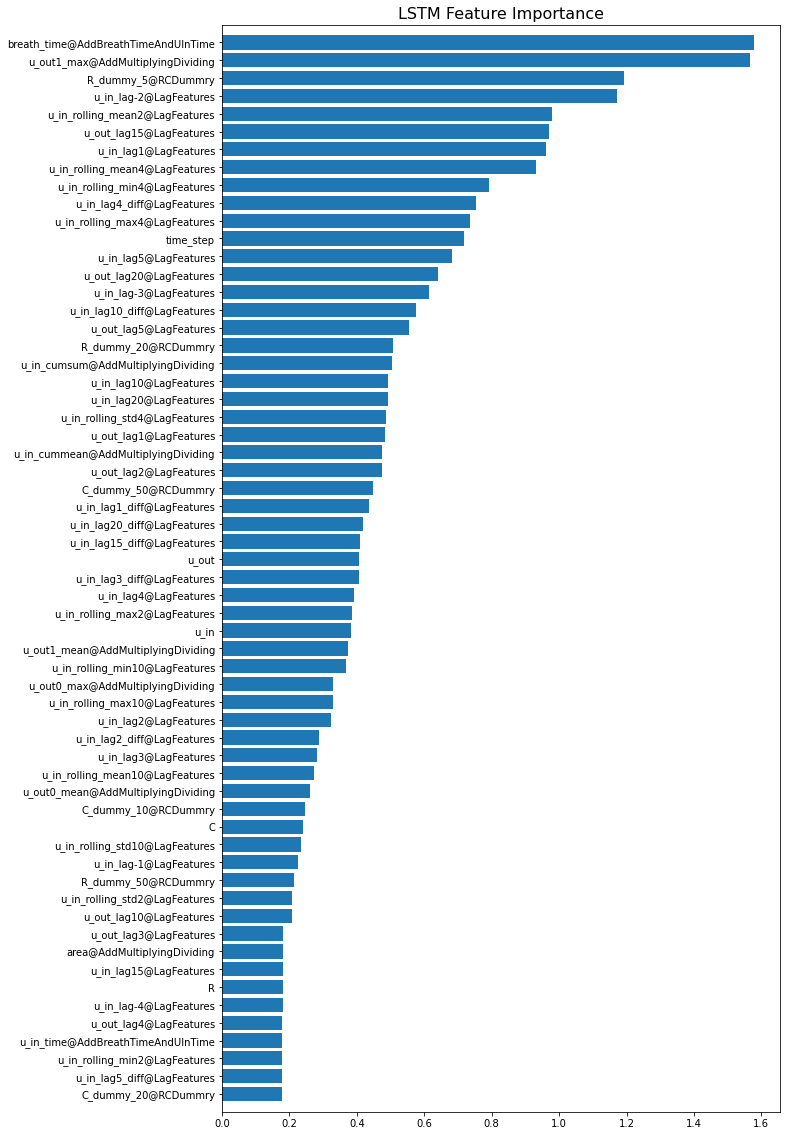

In [27]:
if __name__ == '__main__':
    main()